In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
path = '/Users/jonniebarnsley/data/phd/Control'
csv = pd.read_csv('/Users/jonniebarnsley/Code/phd/Emulation/Pliocene/Pliocene data.csv')

def load(var, at_time):

    var_path = os.path.join(path, var)
    filenames = sorted(os.listdir(var_path))
    filepaths = [os.path.join(var_path, filename) for filename in filenames if 'DS_Store' not in filename]
    files = [xr.open_dataset(filepath, engine='netcdf4') for filepath in filepaths]
    data = [file[var].sel(t=at_time).drop_vars('t') for file in files]
    
    return data

## Thickness

In [3]:
thickness_change_datasets = []
for start, end in zip(load('thickness', 30), load('thickness', 9990)):
    dthk = end.fillna(0)-start.fillna(0) # fill nan with 0 to ensure proper averaging
    thickness_change_datasets.append(dthk)

thickness_ds = xr.concat(thickness_change_datasets, dim='dummy')
mean = thickness_ds.mean(dim='dummy')
std = thickness_ds.std(dim='dummy')

# put nans back in for nicer plotting
ensemble_mean_thickness_change = mean.where(mean != 0)
ensemble_std_thickness_change = std.where(std > 0)

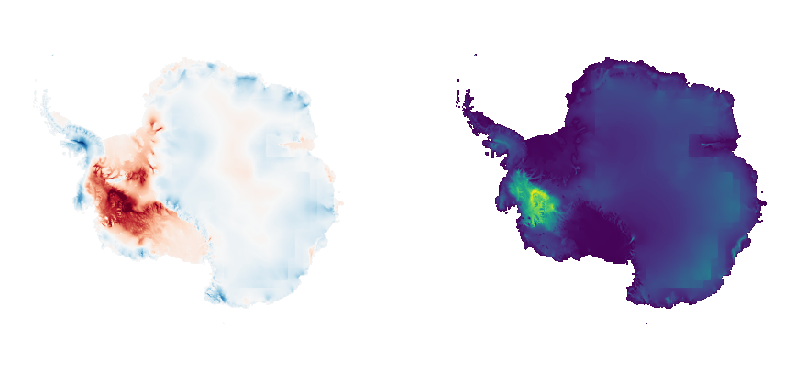

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].pcolormesh(ensemble_mean_thickness_change, cmap='RdBu', vmin=-2000, vmax=2000)
ax[1].pcolormesh(ensemble_std_thickness_change)

for axis in ax:
    axis.set_axis_off()
    axis.set_aspect('equal')

## Grounded Area

In [6]:
# Grounded Area

rhoi = 918  # density of ice
rhoo = 1028 # density of ocean

grounded_area_datasets = []
for zbase, thk in zip(load('Z_base', 9990), load('thickness', 9990)):
    grounded_mask = (thk > -zbase*rhoo/rhoi).astype(int) # floatation criteria
    grounded_area_datasets.append(grounded_mask)

ds = xr.concat(grounded_area_datasets, dim='dummy')
mean = ds.mean(dim='dummy')
proportion_grounded = mean.where(mean > 0) # get rid of grey background

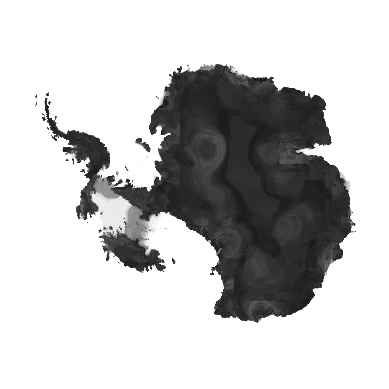

In [11]:
fig, ax = plt.subplots()
ax.pcolormesh(proportion_grounded, cmap='Greys')
ax.set_axis_off()
ax.set_aspect('equal')

## Velocity

In [8]:
speed_datasets = []
for xvel, yvel in zip( load('xVel', 9990), load('yVel', 9990) ):
    speed = np.sqrt(xvel**2 + yvel**2)
    speed_datasets.append(speed)

ensemble_mean_speed = xr.concat(speed_datasets, dim='dummy').mean(dim='dummy')

Text(0.5, 1.0, 'BISICLES')

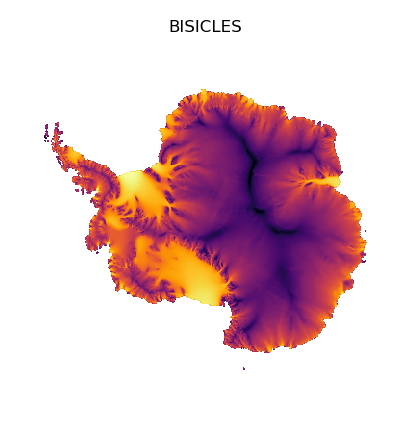

In [40]:
ensemble_std_speed = xr.concat(speed_datasets, dim='dummy').std('dummy')

fig, ax = plt.subplots()
ax.pcolormesh(ensemble_mean_speed, cmap='inferno', norm=mpl.colors.LogNorm())
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('BISICLES')

Text(0.5, 1.0, 'MEaSUREs')

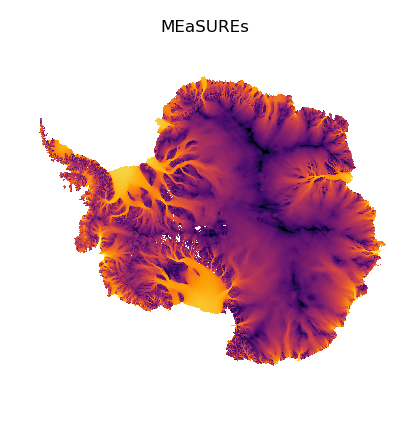

In [10]:
# MEaSUREs InSAR-Based Antarctica Ice Velocity Map
ds = xr.open_dataset('/Users/jonniebarnsley/data/MEaSUREs/antarctic_ice_vel_phase_map_v01.nc')
x_measures = ds.x.values
y_measures = ds.y.values
vx = ds.VX
vy = ds.VY
speed_measures = np.sqrt(vx**2+vy**2)

fig, ax = plt.subplots()
ax.pcolormesh(x_measures, y_measures, speed_measures, norm=mpl.colors.LogNorm(vmin=0.1), cmap='inferno')
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('MEaSUREs')

In [11]:
# MEaSUREs has 450m resolution compared to BISICLES 8km

print(
    'MEaSUREs',
    speed.shape, 
    f'x: {min(x_measures)} to {max(x_measures)}',
    f'y: {min(y_measures)} to {max(y_measures)}',
    '', sep='\n'
)

# Compare with BISICLES
x_bisicles = ensemble_mean_speed.x.values
y_bisicles = ensemble_mean_speed.y.values

print(
    'BSICLES',
    ensemble_mean_speed.shape, 
    f'x2: {min(x_bisicles)} to {max(x_bisicles)}',
    f'y2: {min(y_bisicles)} to {max(y_bisicles)}',
    '', sep='\n'
)

MEaSUREs
(384, 384)
x: -2800000.0 to 2799800.0
y: -2799800.0 to 2800000.0

BSICLES
(384, 384)
x2: 8000.0 to 6136000.0
y2: 8000.0 to 6136000.0



In [12]:
# Add 450m grid squares to MEaSUREs until it has the same extent as BISICLES
num_to_pad = round((max(x_bisicles-8000)/2 - max(x_measures+100))/450) # ± adjustments to center datasets on 0
padded = np.pad(speed_measures, num_to_pad, mode='constant', constant_values=np.nan)
Nx, Ny = padded.shape

# use xarray's interp method to interpolate MEaSUREs onto BISICLES grid
padded_ds = xr.DataArray(
    padded, 
    coords={
        'x': np.linspace(max(x_bisicles), min(x_bisicles), Nx), 
        'y': np.linspace(min(y_bisicles), max(y_bisicles), Ny)
        }, 
    dims=('x', 'y')
    )
measures_on_bisicles_grid = padded_ds.interp(coords = ensemble_mean_speed.coords)
speed_anomaly = ensemble_mean_speed - measures_on_bisicles_grid

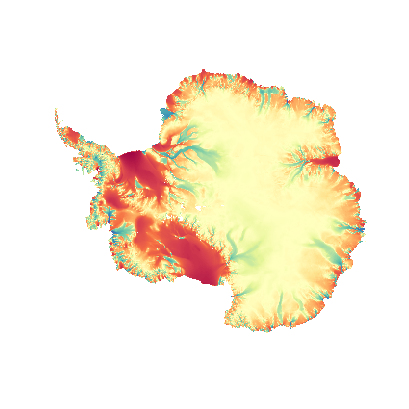

In [13]:
fig, ax = plt.subplots()

ax.pcolormesh(speed_anomaly, norm = mpl.colors.SymLogNorm(10), cmap='Spectral_r')
ax.set_aspect('equal')
ax.set_axis_off()

## Main Plot

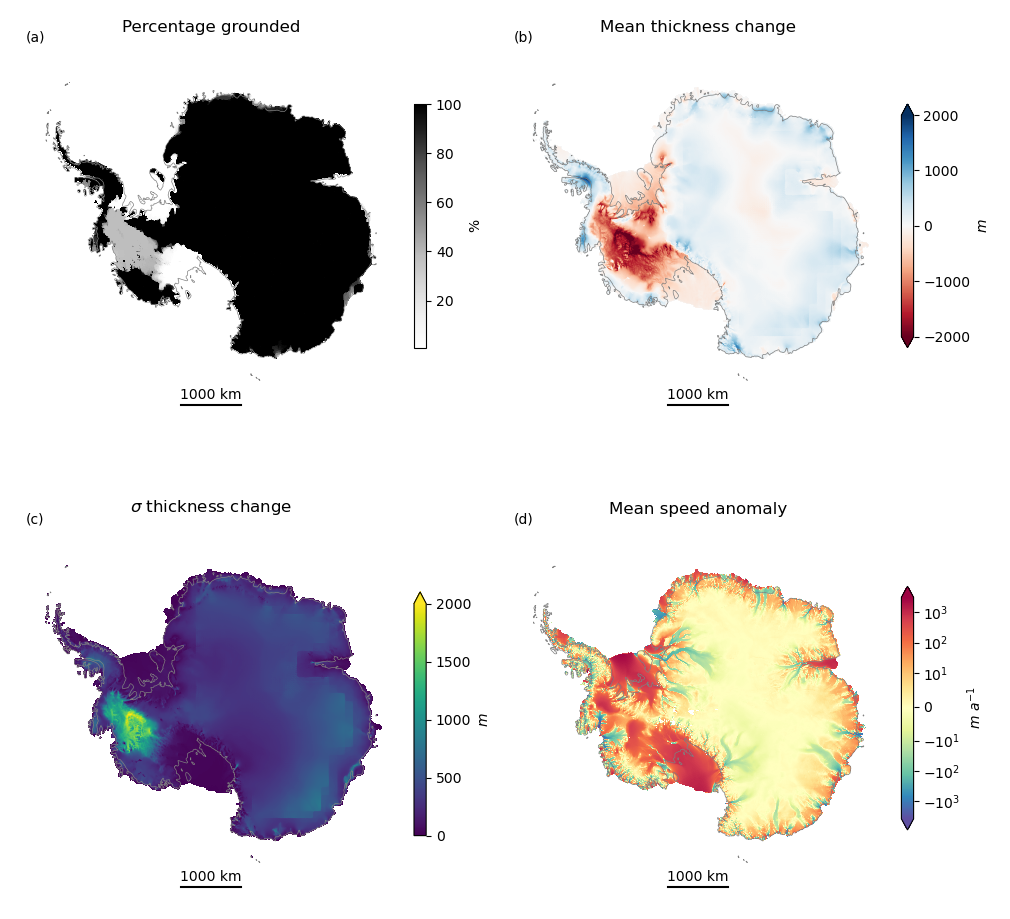

In [161]:
# mpl settings
font = {
    'size': 10,
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans']
    }
mathtext = {
    'fontset': 'dejavusans'
}
savefig = {
    'bbox' : 'tight',
    'pad_inches': 0.2
}
mpl.rc('font', **font)
mpl.rc('mathtext', **mathtext)
mpl.rc('savefig', **savefig)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize = (10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# centre coordinates on 0
mid = max(x_bisicles)/2 # middle of axis for plotting anchors
x = x_bisicles-mid
y = y_bisicles-mid
d = 500_000 # 500 km

# choose axes for plots

grounded_ax = axes[0][0]
mean_tkh_ax = axes[0][1]
std_tkh_ax = axes[1][0]
velocity_ax = axes[1][1]

# plot images
kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
im1 = mean_tkh_ax.pcolormesh(x, y, ensemble_mean_thickness_change, cmap='RdBu', vmin=-2000, vmax=2000, transform=ccrs.Stereographic(**kw))
im2 = std_tkh_ax.pcolormesh(x, y, ensemble_std_thickness_change, cmap='viridis', vmin=0, vmax=2000, transform=ccrs.Stereographic(**kw))
im3 = grounded_ax.pcolormesh(x, y, proportion_grounded*100, cmap='Greys', transform=ccrs.Stereographic(**kw))
im4 = velocity_ax.pcolormesh(x, y, speed_anomaly, cmap='Spectral_r', norm=mpl.colors.SymLogNorm(10), transform=ccrs.Stereographic(**kw))

# axes settings
for ax, letter in zip(axes.flatten(), ['(a)', '(b)', '(c)', '(d)']):
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.plot((-d, +d), (min(y)+100_000, min(y)+100_000), color='black')
    ax.text(0, min(y)+200_000, '1000 km', ha='center', size=10)
    ax.coastlines('50m', lw=0.5, color='grey')
    ax.text(min(x), max(y), letter)

# colorbars
frac = 0.03
pad = 0.03
loc = 'right'
cbar1 = plt.colorbar(im1, ax=mean_tkh_ax, location=loc, pad=pad, fraction=frac, label='$m$', extend='both', ticks=[-2000, -1000, 0, 1000, 2000])
cbar2 = plt.colorbar(im2, ax=std_tkh_ax, location=loc, pad=pad, fraction=frac, label='$m$', extend='max', ticks=[0, 500, 1000, 1500, 2000])
cbar3 = plt.colorbar(im3, ax=grounded_ax, location=loc, pad=pad, fraction=frac, label='%')
cbar4 = plt.colorbar(im4, ax=velocity_ax, location=loc, pad=pad, fraction=frac, label='$m\ a^{-1}$', extend='both')

# axis titles
pad = -0.05
mean_tkh_ax.set_title('Mean thickness change', pad=pad)
std_tkh_ax.set_title('$\sigma$ thickness change', pad=pad)
grounded_ax.set_title('Percentage grounded', pad=pad)
velocity_ax.set_title('Mean speed anomaly', pad=pad)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0)

plt.savefig('../plots/spatialdata.pdf', format='pdf')
plt.savefig('../plots/spatialdata.png', format='png')

        xy2ll: creating coordinates in south polar stereographic (Std Latitude: 71degS Meridian: 0deg)


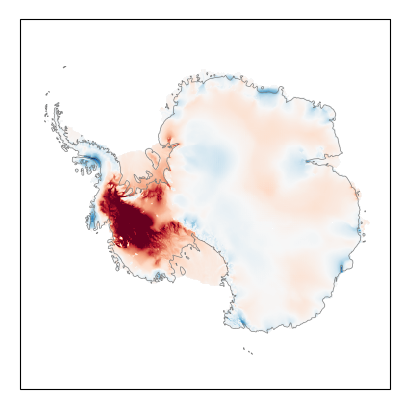

In [135]:
from xy2ll import xy2ll

x = np.array([-1000, 0, 1000])
y = np.array([-1000, 0, 1000])

xs = thickness_ds.x
ys = thickness_ds.y

lat, lon = xy2ll(x, y, -1)

lats, lons = xy2ll(xs-3068000, ys-3068000, -1, 90, 71)


fig = plt.figure()
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.pcolormesh(-lons, lats, thickness_ds[0].where(thickness_ds[0]!=0), transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-2000, vmax=2000)
ax.coastlines(color='grey', lw=0.5)

In [21]:
parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']

print('original:', thickness_ds.shape)
factor=4
coarsened = thickness_ds.coarsen(x=factor, y=factor).mean()

N, Nx, Ny = coarsened.shape
print('coarsened:', coarsened.shape)
A = coarsened.values
A = (A-A.mean())/A.std()
A.shape = (N, Nx*Ny)
print('flattened:', A.shape)

for param in reversed(parameters):
    v = csv[param].values
    v = (v-v.mean())/v.std()
    v = v.reshape(-1, 1)
    A = np.concatenate((v, A), axis=1)
print('with params:', A.shape)

original: (120, 384, 384)
coarsened: (120, 96, 96)
flattened: (120, 9216)
with params: (120, 9221)


In [28]:
C = np.cov(A, rowvar = False)
LAM, E = np.linalg.eig(C)

eof1 = np.reshape(np.real(E[5:,0]), (Ny,Nx))
eof2 = np.reshape(np.real(E[5:,1]), (Ny,Nx))

pc1  = np.dot(A, np.real(E[:,0]))
pc1 = (pc1 - pc1.mean())/pc1.std()
pc2  = np.dot(A, np.real(E[:,1]))
pc2 = (pc2 - pc2.mean())/pc2.std()

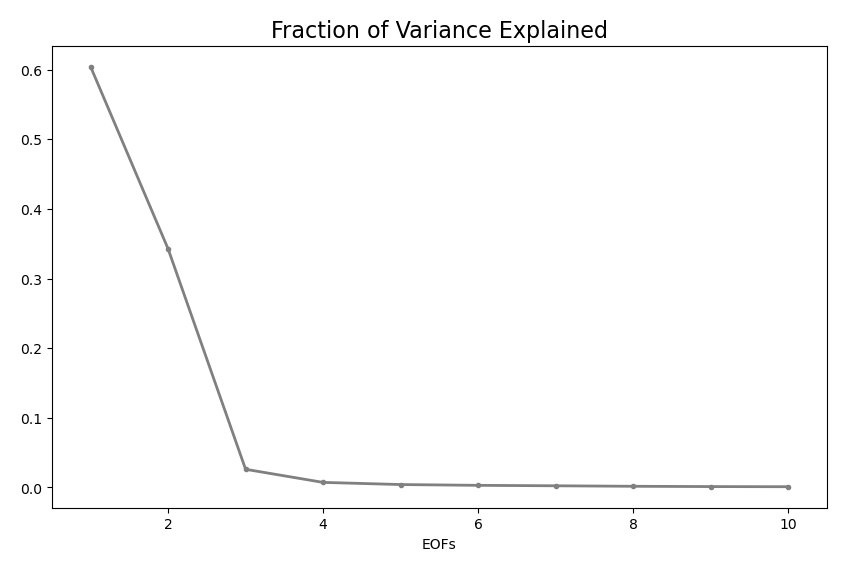

In [30]:
plt.figure(figsize=(10,6))

# plot fraction of variance explained by first 10 eigenvectors using the eigenvalues
plt.plot(np.arange(1,np.size(LAM[:10])+1.),LAM[:10] / LAM.sum(),'.-',color='gray',linewidth=2)
plt.xlim(0.5, 10.5)

# add labels, title, etc.
plt.title('Fraction of Variance Explained',fontsize=16)
plt.xlabel('EOFs')

plt.savefig('../plots/screeplot.svg', format='svg')

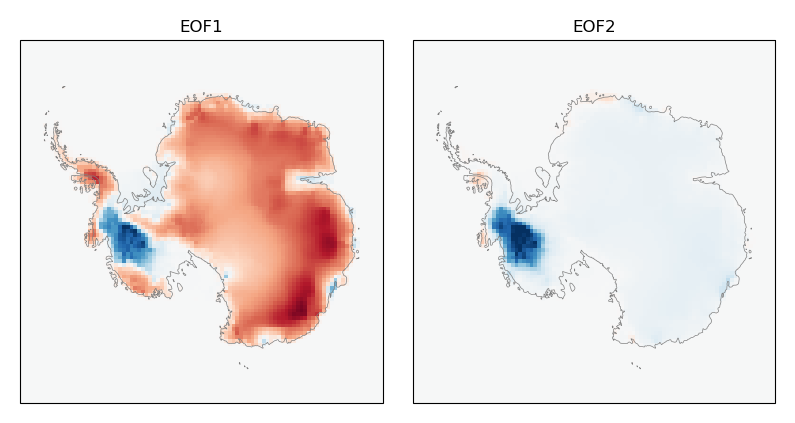

In [168]:
eofx = -xs.coarsen(x=4).mean()
eofy = ys.coarsen(y=4).mean()

eoflat, eoflon = xy2ll(eofx+3068000, eofy-3068000, -1, -90, 71)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# eof1 = np.where(coarse_mask == True, np.nan, eof1)
# eof2 = np.where(coarse_mask == True, np.nan, eof2)

for ax in axes:
    # ax.set_axis_off()
    ax.set_aspect('equal')
    ax.coastlines(color='grey', lw=0.5)

im = axes[0].pcolormesh(eoflon, eoflat, eof1, transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-0.04, vmax=0.04)
#axes[0].pcolormesh(border, cmap='binary')
im2 = axes[1].pcolormesh(eoflon, eoflat, eof2, transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-0.1, vmax=0.1)

axes[0].set_title('EOF1')
axes[1].set_title('EOF2')

# fig.colorbar(im, ax=axes[0], fraction=0.04, ticks=np.arange(-0.1, 0.15, 0.05))
# fig.colorbar(im2, ax=axes[1], fraction=0.04, ticks=np.arange(-0.1, 0.15, 0.05))

fig.tight_layout()
plt.savefig('../plots/eofs.svg', format='svg')
plt.savefig('../plots/eofs.png', format='png')

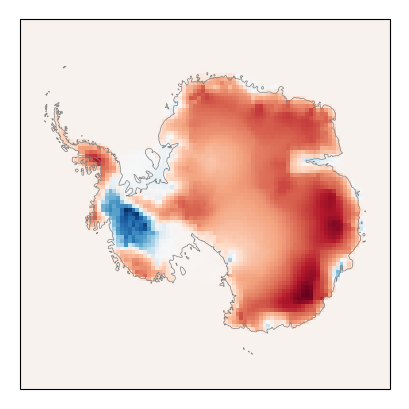

In [160]:
eofx = -xs.coarsen(x=4).mean()
eofy = ys.coarsen(y=4).mean()

eoflat, eoflon = xy2ll(eofx+3068000, eofy-3068000, -1, -90, 71)

fig = plt.figure()
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.pcolormesh(eoflon, eoflat, eof1, transform=ccrs.PlateCarree(), cmap='RdBu')
ax.coastlines(color='grey', lw=0.5)

In [42]:
loadings = pd.DataFrame({
    'PC1': np.real(E[:5, 0]*np.sqrt(np.real(LAM[0]))), 
    'PC2': np.real(E[:5, 1]*np.sqrt(np.real(LAM[1])))}, 
    index=parameters
    )
loadings

,PC1,PC2
gamma0,0.352510,0.698776
UMV,-0.104686,-0.036045
LRP,0.062802,0.014208
PDDi,-0.098257,0.195584
WeertC,-0.952485,0.137563


In [43]:
LAM[:10] / LAM.sum()

array([0.60413508-8.54090101e-33j, 0.34259203-4.84336159e-33j,
       0.02610116-3.69002614e-34j, 0.00729642-1.03152441e-34j,
       0.00421292-5.95597093e-35j, 0.0030695 -4.33948098e-35j,
       0.00242103-3.42270674e-35j, 0.00170797-2.41463143e-35j,
       0.00128934-1.82279412e-35j, 0.00108273-1.53070557e-35j])

In [195]:
df = pd.DataFrame({
    'PC1'   : pc1, 
    'PC2'   : pc2, 
    'gamma0' : csv['gamma0'].values
    })
df.head()

,PC1,PC2,gamma0
0,0.317628,-0.960927,9618.882299
1,1.625094,0.211881,159188.541441
2,1.349357,0.578218,159188.541441
3,0.270647,1.402885,471264.291708
4,-0.179099,1.831365,159188.541441


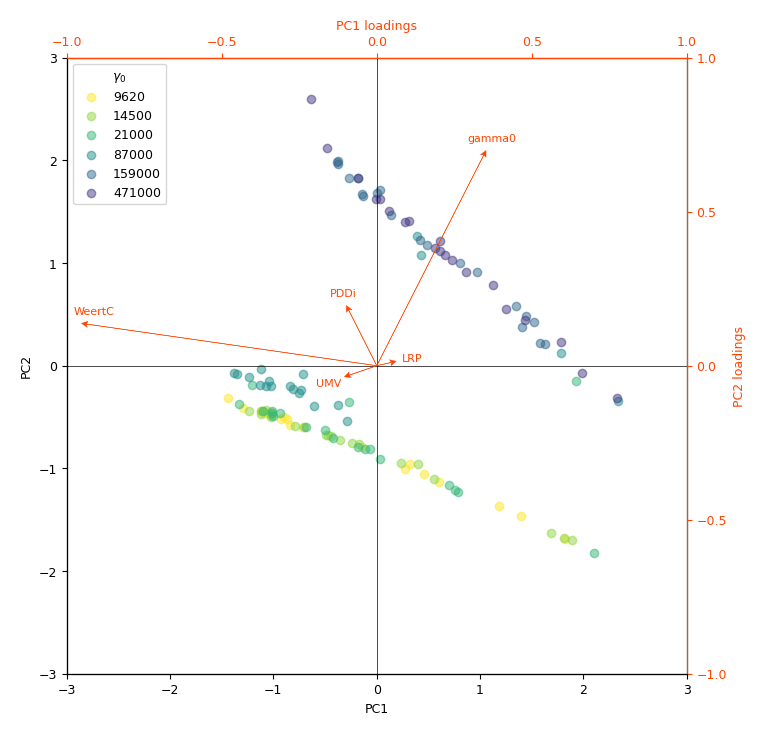

In [196]:
import math

font = {'size': 9}
mpl.rc('font', **font)

def round_to_three_significant_figures(number):
    if number != 0:
        return int(round(number, 3 - int(math.floor(math.log10(abs(number)))) - 1))
    else:
        return 0.0

unique_gamma_values = sorted(csv['gamma0'].unique())
colors = mpl.cm.viridis_r([i / len(unique_gamma_values) for i in range(len(unique_gamma_values))])
gamma_color_map = {gamma_value: colors[i] for i, gamma_value in enumerate(unique_gamma_values)}

fig, ax = plt.subplots(figsize = (8, 8))

by_model = df.groupby('gamma0')

for gamma0, group in by_model:
    ax.scatter(group['PC1'], group['PC2'], alpha=0.5, label=round_to_three_significant_figures(gamma0), color=gamma_color_map[gamma0])
ax.legend(loc='upper left', title='$\gamma_0$')

ax.set_xlim((-3, 3))
ax.set_ylim((-3, 3))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.hlines(0, -3, 3, lw=0.5, color='black')
ax.vlines(0, -3, 3, lw=0.5, color='black')

adjust = {
    'gamma0'   : (0.02, 0.03),
    'LRP'      : (0.05, 0),
    'UMV'      : (-0.05, -0.03),
    'PDDi'     : (-0.01, 0.03),
    'WeertC'   : (0.04, 0.03)
    }

load_color='orangered'
ax2 = ax.twinx()
ax2.tick_params(axis='both', colors=load_color)
ax2.set_ylabel('PC2 loadings', color=load_color)
ax2 = ax2.twiny()
ax2.tick_params(axis='both', colors=load_color)

ax2.set_xticks([-1, -.5, 0, .5, 1])
ax2.set_yticks([-1, -.5, 0, .5, 1])
ax2.set_xlabel('PC1 loadings', color=load_color)
ax2.spines['right'].set_color(load_color)
ax2.spines['top'].set_color(load_color)

for param in parameters:
    coords=loadings.loc[loadings.index == param]
    dx = float(coords['PC1'].iloc[0])
    dy = float(coords['PC2'].iloc[0])
    ax, ay = adjust[param]
    ax2.arrow(0, 0, dx, dy, 
              lw=0.3,
              length_includes_head=True,
              head_width = 0.02,
              head_length=0.02,
              color=load_color,
              overhang=0.2)
    ax2.text(dx+ax, dy+ay, param, ha='center', size=8, color=load_color)

ax2.set_xlim((-1, 1))
ax2.set_ylim((-1, 1))

plt.savefig('../plots/biplot.svg', format='svg')
plt.savefig('../plots/biplot.png', format='png')

0 0
0 1
1 0
1 1
2 0
2 1


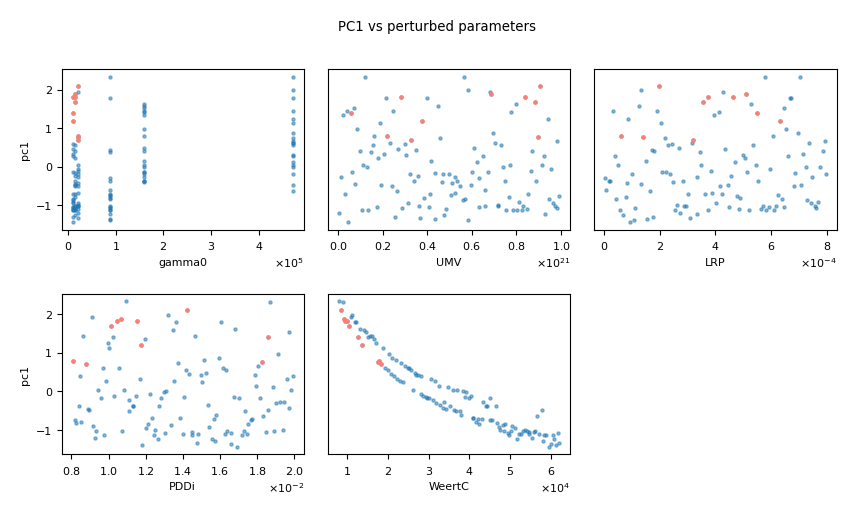

In [189]:
from itertools import product

font = {'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']
weird_runs = [20, 34, 52, 62, 70, 74, 78, 87, 103, 114]
weird_runs = np.array(weird_runs)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))
for param, ax in zip(parameters, axes.flatten()):
    y = pc1
    x = csv[param].values
    ax.scatter(x, y, s=5, alpha=0.5)
    ax.scatter(x[weird_runs-1], y[weird_runs-1], c='salmon', s=5)
    ax.set_xlabel(param)

    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    ax.xaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', scilimits=(-2, 2))

for i, j in product(range(3), range(2)):
    print(i, j)
    if i == 0:
        axes[j][i].set_ylabel('pc1')
    else:
        axes[j][i].tick_params(axis='y', which='both', left=False, labelleft=False)

fig.suptitle('PC1 vs perturbed parameters')
axes[1][2].set_axis_off()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.savefig('../plots/pc1regression.png', format='png')

0 0
0 1
1 0
1 1
2 0
2 1


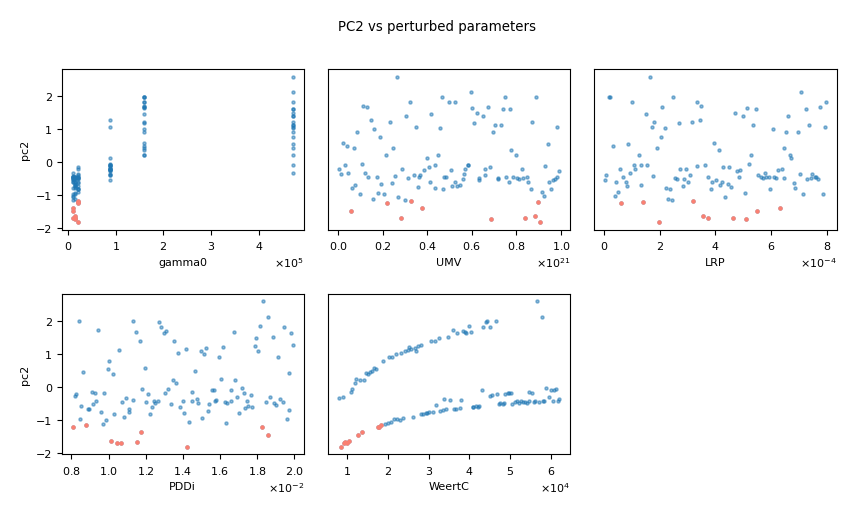

In [191]:
parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))
for param, ax in zip(parameters, axes.flatten()):
    y = pc2
    x = csv[param].values
    ax.scatter(x, y, s=5, alpha=0.5)
    ax.scatter(x[weird_runs-1], y[weird_runs-1], c='salmon', s=5)

    ax.set_xlabel(param)
    #ax.set_ylabel('pc2')

    formatter = mpl.ticker.ScalarFormatter(useMathText=True)
    ax.xaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='sci', scilimits=(-2, 2))

for i, j in product(range(3), range(2)):
    print(i, j)
    if i == 0:
        axes[j][i].set_ylabel('pc2')
    else:
        axes[j][i].tick_params(axis='y', which='both', left=False, labelleft=False)


fig.suptitle('PC2 vs perturbed parameters')
axes[1][2].set_axis_off()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

plt.savefig('../plots/pc2regression.png', format='png')

In [366]:
x = ['1e2', 2, 3]
x = list(map(float, x))
df = pd.DataFrame({'var': x})
y = df['var']+20
df2 = pd.DataFrame({'var':x})
df2['y'] = y
df2

,var,y
0,100.0,120.0
1,2.0,22.0
2,3.0,23.0


In [393]:
import re
x = re.findall('\d+', 'test = 345, test2 = 736')
x = list(map(int, x))
x

[345, 2, 736]

In [394]:
df = pd.DataFrame({'x': x})
df

,x
0,345
1,2
2,736


In [401]:
arr = df['x'].values
arr = np.insert(arr, 0, 5)
arr

array([  5, 345,   2, 736])

In [403]:
3+arr

array([  8, 348,   5, 739])

In [404]:
test = pd.DataFrame({'time': [30, 30, 60, 90, 120], 'val': [1, 2, 3, 4, 5]})
test

,time,val
0,30,1
1,30,2
2,60,3
3,90,4
4,120,5


In [423]:
time = test.time
time = time.drop_duplicates()
time

0     30
2     60
3     90
4    120
Name: time, dtype: int64

In [424]:
time.values

array([ 30,  60,  90, 120])

In [434]:
extended = np.concatenate(time.values, time.values[-1] + 30*np.arange(1, 2))
extended

TypeError: only integer scalar arrays can be converted to a scalar index

In [451]:
test2 = time.values[-1] + 30*np.arange(1, 1)

In [452]:
extended = np.concatenate([time.values, test2])

In [453]:
extended

array([ 30,  60,  90, 120])

In [454]:
test

,time,val
0,30,1
1,30,2
2,60,3
3,90,4
4,120,5


In [455]:
test = test[test['time'] < 100]
test

,time,val
0,30,1
1,30,2
2,60,3
3,90,4


In [456]:
time = test['time'].drop_duplicates().values

elements_to_add = len(test['val']) - len(time)
elements_to_add

1

In [465]:
match = re.search(r'run(\d{3})_control', 'run001_control')

if match:
    print('yes!')

match.group(1)

yes!


'001'

In [466]:
for dir in [1, 2, 3]:
    print(dir)

1
2
3


In [468]:
from pathlib import Path
path = Path('/Users/jonniebarnsley/code/phd/Postprocessing')

sorted(path.iterdir())[0]

PosixPath('/Users/jonniebarnsley/code/phd/Postprocessing/.DS_Store')

In [469]:
df = pd.DataFrame({'VAF': [10], 'bBSL': [20], 'TIV': [30]})
df.head()

,VAF,bBSL,TIV
0,10,20,30


In [470]:
df['VAF']

0    10
Name: VAF, dtype: int64

In [474]:
test['time']+df['VAF'][0]

0     40
1     40
2     70
3    100
Name: time, dtype: int64

In [477]:
df['VAF'].values

array([10])

In [481]:
path = Path('/Users/jonniebarnsley/code/phd/Postprocessing')
for file in path.iterdir():
    print(file.name)

Pliocene_control
.DS_Store
plots


In [487]:
sorted(path.glob('*control/*'))[0]

PosixPath('/Users/jonniebarnsley/code/phd/Postprocessing/Pliocene_control/.DS_Store')

In [489]:
test

,time,val
0,30,1
1,30,2
2,60,3
3,90,4


In [493]:
data = {'time': [30, 30, 60, 90, 120], 'val': [1, 2, 3, 4, 5]}

df = pd.DataFrame(data)
df

,time,val
0,30,1
1,30,2
2,60,3
3,90,4
4,120,5


In [494]:
df['time']

0     30
1     30
2     60
3     90
4    120
Name: time, dtype: int64

In [499]:
new_df = pd.DataFrame({'ex': df['time']})
another = new_df.set_index(np.arange(0, 150, 30))
another

,ex
0,30
30,30
60,60
90,90
120,120


In [502]:
df['time'].iloc[0]

30